<a href="https://colab.research.google.com/github/yichen-qi/LLM_Learn/blob/main/image_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qr https://huggingface.co/briaai/RMBG-1.4/resolve/main/requirements.txt



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00


In [14]:
from google.colab import files
from transformers import AutoModelForImageSegmentation
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import normalize
import numpy as np
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from io import BytesIO

# 上传本地图片
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # 取上传的第一个文件名

# 加载模型
model = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4", trust_remote_code=True)


Saving 2025-05-11_120510_767.jpg to 2025-05-11_120510_767.jpg


## 图像预处理

```python
    im_tensor = torch.tensor(im, dtype=torch.float32).permute(2, 0, 1)
```
`.permute(2, 0, 1)` 将通道维从 (H, W, C) 改成 (C, H, W)，这是 PyTorch 默认的图像格式

```python
    im_tensor = F.interpolate(torch.unsqueeze(im_tensor, 0), size=model_input_size, mode='bilinear')
```
在张量 `im_tensor` 的第 0 维添加一个新维度。`F.interpolate` 要求输入是一个 4维张量：[batch_size, channels, height, width]，所以必须先加 batch 维。

`F.interpolate(...)`对图像（或特征图）进行上采样或下采样用以插值。如果 model_input_size=(256, 256)，原始图像是 [1, 3, 224, 224]，插值后变成 [1, 3, 256, 256]。

```python
    image = torch.divide(im_tensor, 255.0)
```

将像素值从 [0, 255] 归一化到 [0.0, 1.0]。

```python
    image = normalize(image, [0.5, 0.5, 0.5], [1.0, 1.0, 1.0])
```

对图像的每个通道（通常是 RGB 三个颜色通道）进行归一化（normalization）处理
[0.5, 0.5, 0.5] 是 mean，表示对图像的 R、G、B 三个通道分别减去 0.5。
[1.0, 1.0, 1.0] 是 std，表示三个通道的像素值分别 除以 1.0，也就是没有缩放，只是减去 0.5。

In [15]:
# 图像预处理
def preprocess_image(im: np.ndarray, model_input_size: list) -> torch.Tensor:
    if len(im.shape) < 3:
        im = im[:, :, np.newaxis]

    im_tensor = torch.tensor(im, dtype=torch.float32).permute(2, 0, 1)
    im_tensor = F.interpolate(torch.unsqueeze(im_tensor, 0), size=model_input_size, mode='bilinear')
    image = torch.divide(im_tensor, 255.0)
    image = normalize(image, [0.5, 0.5, 0.5], [1.0, 1.0, 1.0])
    return image

## 后处理

```python
    result = torch.squeeze(F.interpolate(result, size=im_size, mode='bilinear'), 0)
```

上采样并去掉 batch 维度，同时恢复图片原本尺寸

```python
    ma = torch.max(result)
    mi = torch.min(result)
    result = (result - mi) / (ma - mi)
    ```

归一化到 [0, 1]

```python
    im_array = (result * 255).permute(1, 2, 0).cpu().data.numpy().astype(np.uint8)
```

转为 NumPy 格式并变为可视化图像,同时将轴从 (C, H, W) 变成 (H, W, C)

```python
    im_array = np.squeeze(im_array)
```

如果 im_array 的形状是 (H, W, 1)，就变成 (H, W)。
如果是 (H, W, 3)（RGB 图像），不会影响。

In [16]:

def postprocess_image(result: torch.Tensor, im_size: list) -> np.ndarray:
    result = torch.squeeze(F.interpolate(result, size=im_size, mode='bilinear'), 0)
    ma = torch.max(result)
    mi = torch.min(result)
    result = (result - mi) / (ma - mi)
    im_array = (result * 255).permute(1, 2, 0).cpu().data.numpy().astype(np.uint8)
    im_array = np.squeeze(im_array)
    return im_array

## 输入图片处理，模型推理，可视化结果

```python
orig_im_size = orig_im.shape[0:2]
```
取出 高和宽（height 和 width）

```python
result_image = postprocess_image(result[0][0], orig_im_size)
```
`result[0][0]`是模型输出的结果是含有两个元素的元组result，元组中第一个元素的第一个元素才是4维的图像数据.
此步骤是将模型输出的结果转换成灰度图

```python
pil_mask_im = Image.fromarray(result_image)
```
将灰度图转换为PIL格式的掩膜，方便后续可视化

```python
no_bg_image = orig_image.convert("RGBA")
no_bg_image.putalpha(pil_mask_im)
```
将原图RGB转为RGBA，多增加了alpha通道，用来控制透明度，根据掩膜的灰度图来删除背景，其中alpha通道的值：255，表示完全不透明（即该像素的颜色完全可见）。0，表示完全透明（即该像素的颜色完全不可见，背景透过来）。

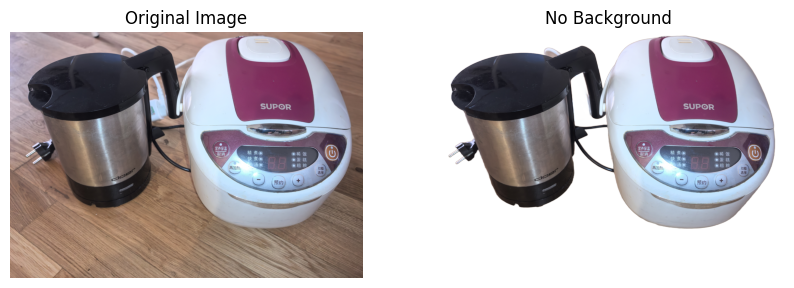

In [17]:
# 设置设备和模型输入尺寸
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model_input_size = [1024, 1024]

# 读取上传的图片
orig_image = Image.open(image_path).convert("RGB")
orig_im = np.array(orig_image)
orig_im_size = orig_im.shape[0:2]

# 推理
image = preprocess_image(orig_im, model_input_size).to(device)
result = model(image)

# 去背景处理
result_image = postprocess_image(result[0][0], orig_im_size)
pil_mask_im = Image.fromarray(result_image)
no_bg_image = orig_image.convert("RGBA")
no_bg_image.putalpha(pil_mask_im)

# 显示对比结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("No Background")
plt.imshow(no_bg_image)
plt.axis("off")
plt.show()